In [1]:
import scanpy as sc
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.sparse
import random
import os

# Set working directory
os.chdir("P:/Tolulope/Manuscript/Yuan Analysis")
adata = sc.read_h5ad('integratedssssss.h5ad')
adata

AnnData object with n_obs × n_vars = 45833 × 37912
    obs: 'batch', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'Sample', '_scvi_batch', '_scvi_labels', 'leiden', '_scvi_raw_norm_scaling', 'cell type', 'condition'
    var: 'n_cells'
    uns: 'Sample_colors', '_scvi_manager_uuid', '_scvi_uuid', 'cell type_colors', 'leiden', 'leiden_colors', 'log1p', 'markers', 'neighbors', 'rank_genes_groups', 'scvi_markers', 'umap'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    layers: 'counts', 'scvi_normalized'
    obsp: 'connectivities', 'distances'

In [2]:
import warnings
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)

In [3]:
import pandas as pd
import numpy as np
import scanpy as sc
import random
import matplotlib.pyplot as plt
import seaborn as sns
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

# -------------------- Pseudobulk Preparation --------------------
# Subset to Dendritic cells only
cell_subset = adata[adata.obs['cell type'] == 'Monocyte/Macrophages']

# Create pseudo-replicates
pbs = []
for sample in cell_subset.obs.Sample.unique():
    samp_cell_subset = cell_subset[cell_subset.obs['Sample'] == sample]
    samp_cell_subset.X = samp_cell_subset.layers['counts']  # Use raw counts

    indices = list(samp_cell_subset.obs_names)
    random.shuffle(indices)
    indices = np.array_split(np.array(indices), 4)  # Adjust for desired number of pseudo-reps

    for i, pseudo_rep in enumerate(indices):
        rep_adata = sc.AnnData(
            X=samp_cell_subset[pseudo_rep].X.sum(axis=0),
            var=samp_cell_subset[pseudo_rep].var[[]]
        )
        rep_adata.obs_names = [sample + '_' + str(i)]
        rep_adata.obs['condition'] = samp_cell_subset.obs['condition'].iloc[0]
        rep_adata.obs['replicate'] = i
        pbs.append(rep_adata)

# Combine pseudobulk replicates
pb = sc.concat(pbs)



In [35]:
counts = pd.DataFrame(pb.X, columns=pb.var_names)  # Convert to DataFrame

# Create DeseqDataSet object with pseudo-replicates
dds = DeseqDataSet(
    counts=counts,
    metadata=pb.obs,
    design_factors=['condition', 'replicate']
)

# Filter genes with low expression
sc.pp.filter_genes(dds, min_cells=1)

# Perform DESeq2 analysis
dds.deseq2()

# Run the Wald test and get results for condition contrast
stat_res = DeseqStats(dds, contrast=('condition', 'YOV-GFP', 'YOV-noGFP'))

# Get the summary of the results (check if this produces a DataFrame)
summary_output = stat_res.summary()
print(type(summary_output))  # This should be a DataFrame
if isinstance(summary_output, pd.DataFrame):
    print(summary_output.head())  # Show the first few rows to inspect

Fitting size factors...
... done in 0.06 seconds.

Fitting dispersions...
... done in 1.42 seconds.

Fitting dispersion trend curve...
... done in 0.73 seconds.

Fitting MAP dispersions...
... done in 3.68 seconds.

Fitting LFCs...
... done in 2.80 seconds.

Calculating cook's distance...
... done in 0.07 seconds.

Replacing 0 outlier genes.

Running Wald tests...


Log2 fold change & Wald test p-value: condition YOV-GFP vs YOV-noGFP
                     baseMean  log2FoldChange     lfcSE      stat    pvalue  \
Gm29155              0.018966        1.427687  5.805682  0.245912  0.805750   
Gm29156              0.043811        0.706345  5.902120  0.119676  0.904739   
Pcmtd1              21.119794        0.046224  0.178443  0.259043  0.795602   
Cdh7                 0.012629        0.706345  5.907597  0.119566  0.904827   
Exo1                 0.035528       -0.014997  5.810001 -0.002581  0.997940   
...                       ...             ...       ...       ...       ...   
ENSMUSG00000144196   0.364952        0.003626  1.778521  0.002039  0.998373   
ENSMUSG00000079808   0.048440       -0.014997  2.291481 -0.006545  0.994778   
ENSMUSG00000095041  15.621588       -0.012892  0.316679 -0.040709  0.967528   
ENSMUSG00000144201   7.226257        0.143067  0.359327  0.398152  0.690518   
Gfp                  0.028216        0.706345  5.709782  0.123

... done in 1.06 seconds.



Available genes in the dataset: ['Syk', 'Lgals3', 'Dock2', 'Coro1a']
   Condition Gene  Expression
0  YSham-GFP  Syk    0.793817
1  YSham-GFP  Syk    0.825092
2  YSham-GFP  Syk    0.719838
3  YSham-GFP  Syk    0.000000
4  YSham-GFP  Syk    0.685521
Number of rows in plot_data: 22580


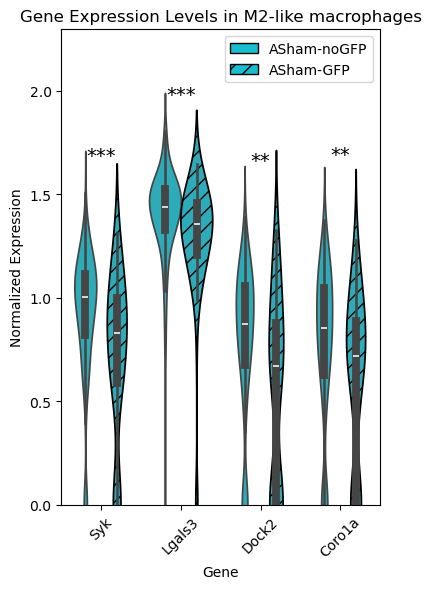

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse
import numpy as np
from matplotlib.patches import Patch

sc.settings.figdir = "FIGURE_3"
# List of genes of interest
genes_of_interest = ['Syk','Lgals3', 'Dock2', 'Coro1a']

# Filter to include only genes present in the dataset
available_genes = [gene for gene in genes_of_interest if gene in cell_subset.raw.var_names]
print(f"Available genes in the dataset: {available_genes}")

# Raise error if none are found
if not available_genes:
    raise ValueError("None of the genes of interest are present in the dataset.")

# Extract expression matrix from .raw
expr_matrix = cell_subset.raw.X.toarray() if scipy.sparse.issparse(cell_subset.raw.X) else cell_subset.raw.X

# Perform log-normalization (log1p) on the expression matrix
normalized_expr_matrix = np.log1p(expr_matrix)

# Create a DataFrame for plotting
data = []
for gene in available_genes:
    gene_index = cell_subset.raw.var_names.get_loc(gene)
    gene_expr = normalized_expr_matrix[:, gene_index]  # Use the normalized expression
    data.append(pd.DataFrame({
        'Condition': cell_subset.obs['condition'].values,
        'Gene': gene,
        'Expression': gene_expr
    }))

plot_data = pd.concat(data, ignore_index=True)

# Debugging
print(plot_data.head())
print(f"Number of rows in plot_data: {len(plot_data)}")

# Raise error if DataFrame is empty
if plot_data.empty:
    raise ValueError("The plot_data DataFrame is empty. Check the gene extraction and subsetting steps.")

# Sort results from stat_res by the 'stat' column in descending order
de = stat_res.results_df
de = de.sort_values('stat', ascending=False)

# Set color palette for the conditions
palette = {'ASham-noGFP': '#17becf', 'ASham-GFP': '#17becf'}

# Plot violin plot
plt.figure(figsize=(4, 6))
ax = sns.violinplot(
    x='Gene',
    y='Expression',
    hue='Condition',
    data=plot_data,
    palette=palette,
    inner='box',
    hue_order=['ASham-noGFP', 'ASham-GFP']
)

# Apply hatch pattern only to ASham-GFP violins
for i, artist in enumerate(ax.collections):
    if i % 2 == 1:  # ASham-GFP (2nd hue in each gene group)
        artist.set_hatch('//')
        artist.set_edgecolor('black')  # optional: make hatch clearer

# Annotate statistical significance
max_expr = plot_data['Expression'].max()
line_spacing = max_expr * 0.15
text_offset = max_expr * 0.025

for i, gene in enumerate(available_genes):
    gene_data = plot_data[plot_data['Gene'] == gene]
    
    # Padj from your DE results
    padj = de.loc[gene, 'padj'] if gene in de.index else 1.0
    padj = 1.0 if pd.isna(padj) else padj
    
    # Significance symbol
    symbol = '***' if padj < 0.001 else '**' if padj < 0.01 else '*' if padj < 0.05 else 'ns'
    
    # Get maximum box height per gene (from both conditions)
    max_expr_per_gene = gene_data.groupby('Condition')['Expression'].max().max()

    # Small offset above the top box/violin for placing the text
    y = max_expr_per_gene + 0.1  # Adjust as needed
    x = i  # center of the gene group

    ax.text(x, y, symbol, ha='center', va='bottom', fontsize=14)


# Axis settings
plt.ylim(0, plot_data['Expression'].max() * 1.25)
plt.title('Gene Expression Levels in M2-like macrophages')
plt.ylabel('Normalized Expression')
plt.xticks(rotation=45)

# Custom legend with hatch pattern
legend_elements = [
    Patch(facecolor='#17becf', edgecolor='black', label='ASham-noGFP'),
    Patch(facecolor='#17becf', edgecolor='black', hatch='//', label='ASham-GFP')
]
plt.legend(handles=legend_elements)

# Save and show plot
plt.tight_layout()
plt.savefig('Violin_YSham_GFP vs YSham_noGFP_Residence_Down3.png')
plt.show()


In [ ]:
#YOV RES

Available genes in the dataset: ['Col1a1', 'Col3a1', 'Col1a2']
   Condition    Gene  Expression
0  YSham-GFP  Col1a1         0.0
1  YSham-GFP  Col1a1         0.0
2  YSham-GFP  Col1a1         0.0
3  YSham-GFP  Col1a1         0.0
4  YSham-GFP  Col1a1         0.0
Number of rows in plot_data: 16935


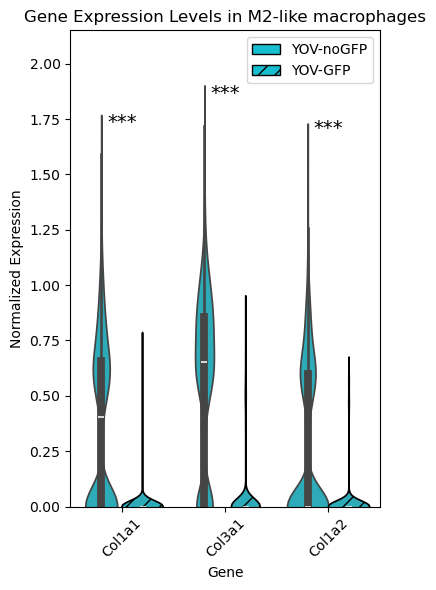

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse
import numpy as np
from matplotlib.patches import Patch

sc.settings.figdir = "FIGURE_3"
# List of genes of interest
genes_of_interest = ['Col1a1','Col3a1', 'Col1a2']

# Filter to include only genes present in the dataset
available_genes = [gene for gene in genes_of_interest if gene in cell_subset.raw.var_names]
print(f"Available genes in the dataset: {available_genes}")

# Raise error if none are found
if not available_genes:
    raise ValueError("None of the genes of interest are present in the dataset.")

# Extract expression matrix from .raw
expr_matrix = cell_subset.raw.X.toarray() if scipy.sparse.issparse(cell_subset.raw.X) else cell_subset.raw.X

# Perform log-normalization (log1p) on the expression matrix
normalized_expr_matrix = np.log1p(expr_matrix)

# Create a DataFrame for plotting
data = []
for gene in available_genes:
    gene_index = cell_subset.raw.var_names.get_loc(gene)
    gene_expr = normalized_expr_matrix[:, gene_index]  # Use the normalized expression
    data.append(pd.DataFrame({
        'Condition': cell_subset.obs['condition'].values,
        'Gene': gene,
        'Expression': gene_expr
    }))

plot_data = pd.concat(data, ignore_index=True)

# Debugging
print(plot_data.head())
print(f"Number of rows in plot_data: {len(plot_data)}")

# Raise error if DataFrame is empty
if plot_data.empty:
    raise ValueError("The plot_data DataFrame is empty. Check the gene extraction and subsetting steps.")

# Sort results from stat_res by the 'stat' column in descending order
de = stat_res.results_df
de = de.sort_values('stat', ascending=False)

# Set color palette for the conditions
palette = {'YOV-noGFP': '#17becf', 'YOV-GFP': '#17becf'}

# Plot violin plot
plt.figure(figsize=(4, 6))
ax = sns.violinplot(
    x='Gene',
    y='Expression',
    hue='Condition',
    data=plot_data,
    palette=palette,
    inner='box',
    hue_order=['YOV-noGFP', 'YOV-GFP']
)

# Apply hatch pattern only to ASham-GFP violins
for i, artist in enumerate(ax.collections):
    if i % 2 == 1:  # ASham-GFP (2nd hue in each gene group)
        artist.set_hatch('//')
        artist.set_edgecolor('black')  # optional: make hatch clearer

# Annotate statistical significance
max_expr = plot_data['Expression'].max()
line_spacing = max_expr * 0.15
text_offset = max_expr * 0.025

for i, gene in enumerate(available_genes):
    gene_data = plot_data[plot_data['Gene'] == gene]
    
    # Padj from your DE results
    padj = de.loc[gene, 'padj'] if gene in de.index else 1.0
    padj = 1.0 if pd.isna(padj) else padj
    
    # Significance symbol
    symbol = '***' if padj < 0.001 else '**' if padj < 0.01 else '*' if padj < 0.05 else 'ns'
    
    # Get maximum box height per gene (from both conditions)
    max_expr_per_gene = gene_data.groupby('Condition')['Expression'].max().max()

    # Small offset above the top box/violin for placing the text
    y = max_expr_per_gene + 0.1  # Adjust as needed
    x = i  # center of the gene group

    ax.text(x, y, symbol, ha='center', va='bottom', fontsize=14)


# Axis settings
plt.ylim(0, plot_data['Expression'].max() * 1.25)
plt.title('Gene Expression Levels in M2-like macrophages')
plt.ylabel('Normalized Expression')
plt.xticks(rotation=45)

# Custom legend with hatch pattern
legend_elements = [
    Patch(facecolor='#17becf', edgecolor='black', label='YOV-noGFP'),
    Patch(facecolor='#17becf', edgecolor='black', hatch='//', label='YOV-GFP')
]
plt.legend(handles=legend_elements)

# Save and show plot
plt.tight_layout()
plt.savefig('Violin_YOV_GFP vs YOV_noGFP_Residence_DOWN.png')
plt.show()


Available genes in the dataset: ['C1qc', 'Trem2', 'Mrc1']
   Condition  Gene  Expression
0  YSham-GFP  C1qc    1.313321
1  YSham-GFP  C1qc    1.498175
2  YSham-GFP  C1qc    1.346771
3  YSham-GFP  C1qc    1.207455
4  YSham-GFP  C1qc    1.596972
Number of rows in plot_data: 16935


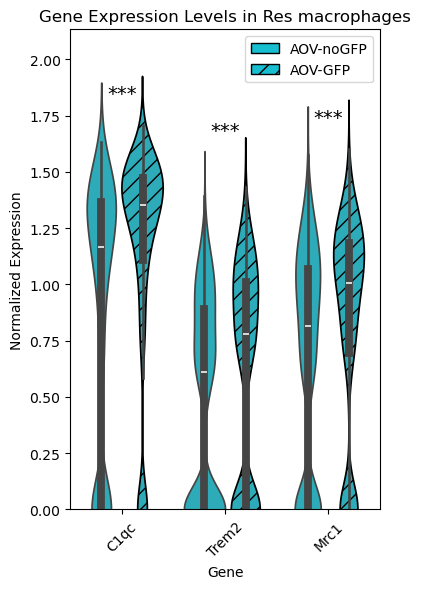

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse
import numpy as np
from matplotlib.patches import Patch

sc.settings.figdir = "FIGURE_3"
# List of genes of interest
genes_of_interest = ['C1qc','Trem2','Mrc1']

# Filter to include only genes present in the dataset
available_genes = [gene for gene in genes_of_interest if gene in cell_subset.raw.var_names]
print(f"Available genes in the dataset: {available_genes}")

# Raise error if none are found
if not available_genes:
    raise ValueError("None of the genes of interest are present in the dataset.")

# Extract expression matrix from .raw
expr_matrix = cell_subset.raw.X.toarray() if scipy.sparse.issparse(cell_subset.raw.X) else cell_subset.raw.X

# Perform log-normalization (log1p) on the expression matrix
normalized_expr_matrix = np.log1p(expr_matrix)

# Create a DataFrame for plotting
data = []
for gene in available_genes:
    gene_index = cell_subset.raw.var_names.get_loc(gene)
    gene_expr = normalized_expr_matrix[:, gene_index]  # Use the normalized expression
    data.append(pd.DataFrame({
        'Condition': cell_subset.obs['condition'].values,
        'Gene': gene,
        'Expression': gene_expr
    }))

plot_data = pd.concat(data, ignore_index=True)

# Debugging
print(plot_data.head())
print(f"Number of rows in plot_data: {len(plot_data)}")

# Raise error if DataFrame is empty
if plot_data.empty:
    raise ValueError("The plot_data DataFrame is empty. Check the gene extraction and subsetting steps.")

# Sort results from stat_res by the 'stat' column in descending order
de = stat_res.results_df
de = de.sort_values('stat', ascending=False)

# Set color palette for the conditions
palette = {'AOV-noGFP': '#17becf', 'AOV-GFP': '#17becf'}

# Plot violin plot
plt.figure(figsize=(4, 6))
ax = sns.violinplot(
    x='Gene',
    y='Expression',
    hue='Condition',
    data=plot_data,
    palette=palette,
    inner='box',
    hue_order=['AOV-noGFP', 'AOV-GFP']
)

# Apply hatch pattern only to ASham-GFP violins
for i, artist in enumerate(ax.collections):
    if i % 2 == 1:  # ASham-GFP (2nd hue in each gene group)
        artist.set_hatch('//')
        artist.set_edgecolor('black')  # optional: make hatch clearer

# Annotate statistical significance
max_expr = plot_data['Expression'].max()
line_spacing = max_expr * 0.15
text_offset = max_expr * 0.025

for i, gene in enumerate(available_genes):
    gene_data = plot_data[plot_data['Gene'] == gene]
    
    # Padj from your DE results
    padj = de.loc[gene, 'padj'] if gene in de.index else 1.0
    padj = 1.0 if pd.isna(padj) else padj
    
    # Significance symbol
    symbol = '***' if padj < 0.001 else '**' if padj < 0.01 else '*' if padj < 0.05 else 'ns'
    
    # Get maximum box height per gene (from both conditions)
    max_expr_per_gene = gene_data.groupby('Condition')['Expression'].max().max()

    # Small offset above the top box/violin for placing the text
    y = max_expr_per_gene + 0.1  # Adjust as needed
    x = i  # center of the gene group

    ax.text(x, y, symbol, ha='center', va='bottom', fontsize=14)


# Axis settings
plt.ylim(0, plot_data['Expression'].max() * 1.25)
plt.title('Gene Expression Levels in Res macrophages')
plt.ylabel('Normalized Expression')
plt.xticks(rotation=45)

# Custom legend with hatch pattern
legend_elements = [
    Patch(facecolor='#17becf', edgecolor='black', label='AOV-noGFP'),
    Patch(facecolor='#17becf', edgecolor='black', hatch='//', label='AOV-GFP')
]
plt.legend(handles=legend_elements)

# Save and show plot
plt.tight_layout()
plt.savefig('Violin_AOV_GFP vs AOV_noGFP_Residence_DOWN8.png')
plt.show()


Available genes in the dataset: ['Gas6', 'Trem2', 'Fer']
   Condition  Gene  Expression
0  YSham-GFP  Gas6    0.968872
1  YSham-GFP  Gas6    0.733744
2  YSham-GFP  Gas6    0.394982
3  YSham-GFP  Gas6    0.576003
4  YSham-GFP  Gas6    1.265489
Number of rows in plot_data: 16935


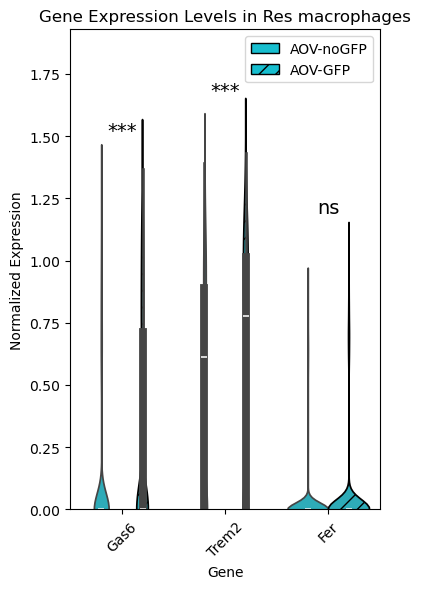

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse
import numpy as np
from matplotlib.patches import Patch

sc.settings.figdir = "FIGURE_3"
# List of genes of interest
genes_of_interest = ['Gas6', 'Trem2', 'Fer']

# Filter to include only genes present in the dataset
available_genes = [gene for gene in genes_of_interest if gene in cell_subset.raw.var_names]
print(f"Available genes in the dataset: {available_genes}")

# Raise error if none are found
if not available_genes:
    raise ValueError("None of the genes of interest are present in the dataset.")

# Extract expression matrix from .raw
expr_matrix = cell_subset.raw.X.toarray() if scipy.sparse.issparse(cell_subset.raw.X) else cell_subset.raw.X

# Perform log-normalization (log1p) on the expression matrix
normalized_expr_matrix = np.log1p(expr_matrix)

# Create a DataFrame for plotting
data = []
for gene in available_genes:
    gene_index = cell_subset.raw.var_names.get_loc(gene)
    gene_expr = normalized_expr_matrix[:, gene_index]  # Use the normalized expression
    data.append(pd.DataFrame({
        'Condition': cell_subset.obs['condition'].values,
        'Gene': gene,
        'Expression': gene_expr
    }))

plot_data = pd.concat(data, ignore_index=True)

# Debugging
print(plot_data.head())
print(f"Number of rows in plot_data: {len(plot_data)}")

# Raise error if DataFrame is empty
if plot_data.empty:
    raise ValueError("The plot_data DataFrame is empty. Check the gene extraction and subsetting steps.")

# Sort results from stat_res by the 'stat' column in descending order
de = stat_res.results_df
de = de.sort_values('stat', ascending=False)

# Set color palette for the conditions
palette = {'AOV-noGFP': '#17becf', 'AOV-GFP': '#17becf'}

# Plot violin plot
plt.figure(figsize=(4, 6))
ax = sns.violinplot(
    x='Gene',
    y='Expression',
    hue='Condition',
    data=plot_data,
    palette=palette,
    inner='box',
    hue_order=['AOV-noGFP', 'AOV-GFP']
)

# Apply hatch pattern only to ASham-GFP violins
for i, artist in enumerate(ax.collections):
    if i % 2 == 1:  # ASham-GFP (2nd hue in each gene group)
        artist.set_hatch('//')
        artist.set_edgecolor('black')  # optional: make hatch clearer

# Annotate statistical significance
max_expr = plot_data['Expression'].max()
line_spacing = max_expr * 0.15
text_offset = max_expr * 0.025

for i, gene in enumerate(available_genes):
    gene_data = plot_data[plot_data['Gene'] == gene]
    
    # Padj from your DE results
    padj = de.loc[gene, 'padj'] if gene in de.index else 1.0
    padj = 1.0 if pd.isna(padj) else padj
    
    # Significance symbol
    symbol = '***' if padj < 0.001 else '**' if padj < 0.01 else '*' if padj < 0.05 else 'ns'
    
    # Get maximum box height per gene (from both conditions)
    max_expr_per_gene = gene_data.groupby('Condition')['Expression'].max().max()

    # Small offset above the top box/violin for placing the text
    y = max_expr_per_gene + 0.1  # Adjust as needed
    x = i  # center of the gene group

    ax.text(x, y, symbol, ha='center', va='bottom', fontsize=14)


# Axis settings
plt.ylim(0, plot_data['Expression'].max() * 1.25)
plt.title('Gene Expression Levels in Res macrophages')
plt.ylabel('Normalized Expression')
plt.xticks(rotation=45)

# Custom legend with hatch pattern
legend_elements = [
    Patch(facecolor='#17becf', edgecolor='black', label='AOV-noGFP'),
    Patch(facecolor='#17becf', edgecolor='black', hatch='//', label='AOV-GFP')
]
plt.legend(handles=legend_elements)

# Save and show plot
plt.tight_layout()
plt.savefig('Violin_AOV_GFP vs AOV_noGFP_Residence_UP00.png')
plt.show()


Available genes in the dataset: ['Atp5f1e', 'Atp5if1', 'Cox6c', 'Ndufa13']
   Condition     Gene  Expression
0  YSham-GFP  Atp5f1e    0.710859
1  YSham-GFP  Atp5f1e    0.000000
2  YSham-GFP  Atp5f1e    0.638463
3  YSham-GFP  Atp5f1e    0.950824
4  YSham-GFP  Atp5f1e    0.629637
Number of rows in plot_data: 15216


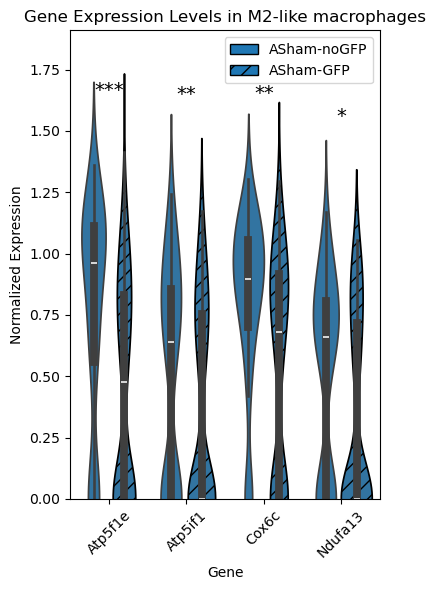

In [48]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse
import numpy as np
from matplotlib.patches import Patch

sc.settings.figdir = "FIGURE_3"
# List of genes of interest
genes_of_interest = ['Atp5f1e','Atp5if1','Cox6c', 'Ndufa13']

# Filter to include only genes present in the dataset
available_genes = [gene for gene in genes_of_interest if gene in cell_subset.raw.var_names]
print(f"Available genes in the dataset: {available_genes}")

# Raise error if none are found
if not available_genes:
    raise ValueError("None of the genes of interest are present in the dataset.")

# Extract expression matrix from .raw
expr_matrix = cell_subset.raw.X.toarray() if scipy.sparse.issparse(cell_subset.raw.X) else cell_subset.raw.X

# Perform log-normalization (log1p) on the expression matrix
normalized_expr_matrix = np.log1p(expr_matrix)

# Create a DataFrame for plotting
data = []
for gene in available_genes:
    gene_index = cell_subset.raw.var_names.get_loc(gene)
    gene_expr = normalized_expr_matrix[:, gene_index]  # Use the normalized expression
    data.append(pd.DataFrame({
        'Condition': cell_subset.obs['condition'].values,
        'Gene': gene,
        'Expression': gene_expr
    }))

plot_data = pd.concat(data, ignore_index=True)

# Debugging
print(plot_data.head())
print(f"Number of rows in plot_data: {len(plot_data)}")

# Raise error if DataFrame is empty
if plot_data.empty:
    raise ValueError("The plot_data DataFrame is empty. Check the gene extraction and subsetting steps.")

# Sort results from stat_res by the 'stat' column in descending order
de = stat_res.results_df
de = de.sort_values('stat', ascending=False)

# Set color palette for the conditions
palette = {'YOV-noGFP': '#17becf', 'YOV-GFP': '#17becf'}

# Plot violin plot
plt.figure(figsize=(4, 6))
ax = sns.violinplot(
    x='Gene',
    y='Expression',
    hue='Condition',
    data=plot_data,
    palette=palette,
    inner='box',
    hue_order=['YSham-noGFP', 'YSham-GFP']
)

# Apply hatch pattern only to ASham-GFP violins
for i, artist in enumerate(ax.collections):
    if i % 2 == 1:  # ASham-GFP (2nd hue in each gene group)
        artist.set_hatch('//')
        artist.set_edgecolor('black')  # optional: make hatch clearer

# Annotate statistical significance
max_expr = plot_data['Expression'].max()
line_spacing = max_expr * 0.15
text_offset = max_expr * 0.025

for i, gene in enumerate(available_genes):
    gene_data = plot_data[plot_data['Gene'] == gene]
    
    # Padj from your DE results
    padj = de.loc[gene, 'padj'] if gene in de.index else 1.0
    padj = 1.0 if pd.isna(padj) else padj
    
    # Significance symbol
    symbol = '***' if padj < 0.001 else '**' if padj < 0.01 else '*' if padj < 0.05 else 'ns'
    
    # Get maximum box height per gene (from both conditions)
    max_expr_per_gene = gene_data.groupby('Condition')['Expression'].max().max()

    # Small offset above the top box/violin for placing the text
    y = max_expr_per_gene + 0.1  # Adjust as needed
    x = i  # center of the gene group

    ax.text(x, y, symbol, ha='center', va='bottom', fontsize=14)


# Axis settings
plt.ylim(0, plot_data['Expression'].max() * 1.25)
plt.title('Gene Expression Levels in M2-like macrophages')
plt.ylabel('Normalized Expression')
plt.xticks(rotation=45)

# Custom legend with hatch pattern
legend_elements = [
    Patch(facecolor='#17becf', edgecolor='black', label='YSham-noGFP'),
    Patch(facecolor='#17becf', edgecolor='black', hatch='//', label='YSham-GFP')
]
plt.legend(handles=legend_elements)

# Save and show plot
plt.tight_layout()
plt.savefig('Violin_YSham_GFP vs YSham_noGFP_Residence_Down.png')
plt.show()


In [ ]:
#OV M2

Available genes in the dataset: ['Col1a1', 'Col1a2', 'Col3a1']
   Condition    Gene  Expression
0  YSham-GFP  Col1a1    0.000000
1  YSham-GFP  Col1a1    0.000000
2  YSham-GFP  Col1a1    0.000000
3  YSham-GFP  Col1a1    0.454792
4  YSham-GFP  Col1a1    0.000000
Number of rows in plot_data: 11412


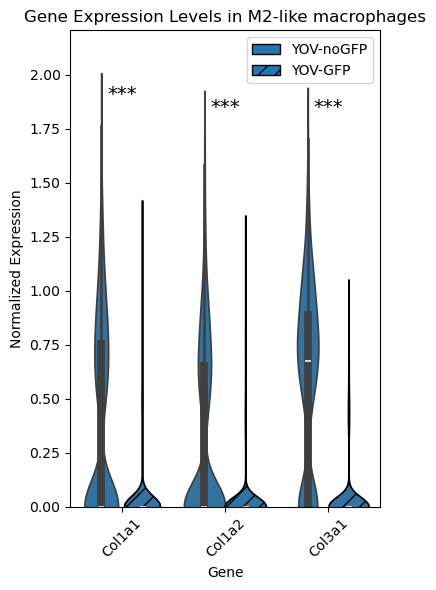

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse
import numpy as np
from matplotlib.patches import Patch

sc.settings.figdir = "FIGURE_3"
# List of genes of interest
genes_of_interest = ['Col1a1','Col1a2','Col3a1']

# Filter to include only genes present in the dataset
available_genes = [gene for gene in genes_of_interest if gene in cell_subset.raw.var_names]
print(f"Available genes in the dataset: {available_genes}")

# Raise error if none are found
if not available_genes:
    raise ValueError("None of the genes of interest are present in the dataset.")

# Extract expression matrix from .raw
expr_matrix = cell_subset.raw.X.toarray() if scipy.sparse.issparse(cell_subset.raw.X) else cell_subset.raw.X

# Perform log-normalization (log1p) on the expression matrix
normalized_expr_matrix = np.log1p(expr_matrix)

# Create a DataFrame for plotting
data = []
for gene in available_genes:
    gene_index = cell_subset.raw.var_names.get_loc(gene)
    gene_expr = normalized_expr_matrix[:, gene_index]  # Use the normalized expression
    data.append(pd.DataFrame({
        'Condition': cell_subset.obs['condition'].values,
        'Gene': gene,
        'Expression': gene_expr
    }))

plot_data = pd.concat(data, ignore_index=True)

# Debugging
print(plot_data.head())
print(f"Number of rows in plot_data: {len(plot_data)}")

# Raise error if DataFrame is empty
if plot_data.empty:
    raise ValueError("The plot_data DataFrame is empty. Check the gene extraction and subsetting steps.")

# Sort results from stat_res by the 'stat' column in descending order
de = stat_res.results_df
de = de.sort_values('stat', ascending=False)

# Set color palette for the conditions
palette = {'YOV-noGFP': '#1f77b4', 'YOV-GFP': '#1f77b4'}

# Plot violin plot
plt.figure(figsize=(4, 6))
ax = sns.violinplot(
    x='Gene',
    y='Expression',
    hue='Condition',
    data=plot_data,
    palette=palette,
    inner='box',
    hue_order=['YOV-noGFP', 'YOV-GFP']
)

# Apply hatch pattern only to ASham-GFP violins
for i, artist in enumerate(ax.collections):
    if i % 2 == 1:  # ASham-GFP (2nd hue in each gene group)
        artist.set_hatch('//')
        artist.set_edgecolor('black')  # optional: make hatch clearer

# Annotate statistical significance
max_expr = plot_data['Expression'].max()
line_spacing = max_expr * 0.15
text_offset = max_expr * 0.025

for i, gene in enumerate(available_genes):
    gene_data = plot_data[plot_data['Gene'] == gene]
    
    # Padj from your DE results
    padj = de.loc[gene, 'padj'] if gene in de.index else 1.0
    padj = 1.0 if pd.isna(padj) else padj
    
    # Significance symbol
    symbol = '***' if padj < 0.001 else '**' if padj < 0.01 else '*' if padj < 0.05 else 'ns'
    
    # Get maximum box height per gene (from both conditions)
    max_expr_per_gene = gene_data.groupby('Condition')['Expression'].max().max()

    # Small offset above the top box/violin for placing the text
    y = max_expr_per_gene + 0.1  # Adjust as needed
    x = i  # center of the gene group

    ax.text(x, y, symbol, ha='center', va='bottom', fontsize=14)


# Axis settings
plt.ylim(0, plot_data['Expression'].max() * 1.25)
plt.title('Gene Expression Levels in M2-like macrophages')
plt.ylabel('Normalized Expression')
plt.xticks(rotation=45)

# Custom legend with hatch pattern
legend_elements = [
    Patch(facecolor='#1f77b4', edgecolor='black', label='YOV-noGFP'),
    Patch(facecolor='#1f77b4', edgecolor='black', hatch='//', label='YOV-GFP')
]
plt.legend(handles=legend_elements)

# Save and show plot
plt.tight_layout()
plt.savefig('Violin_YOV_GFP vs YOV_noGFP_M2_Down.png')
plt.show()


Available genes in the dataset: ['Gas6', 'Notch2', 'Igf1']
   Condition  Gene  Expression
0  YSham-GFP  Gas6    1.246113
1  YSham-GFP  Gas6    0.760804
2  YSham-GFP  Gas6    0.000000
3  YSham-GFP  Gas6    1.310783
4  YSham-GFP  Gas6    0.918698
Number of rows in plot_data: 11412


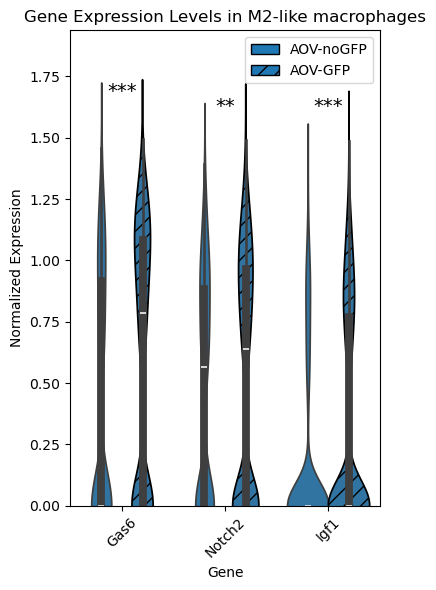

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse
import numpy as np
from matplotlib.patches import Patch

sc.settings.figdir = "FIGURE_3"
# List of genes of interest
genes_of_interest = ['Gas6','Notch2','Igf1']

# Filter to include only genes present in the dataset
available_genes = [gene for gene in genes_of_interest if gene in cell_subset.raw.var_names]
print(f"Available genes in the dataset: {available_genes}")

# Raise error if none are found
if not available_genes:
    raise ValueError("None of the genes of interest are present in the dataset.")

# Extract expression matrix from .raw
expr_matrix = cell_subset.raw.X.toarray() if scipy.sparse.issparse(cell_subset.raw.X) else cell_subset.raw.X

# Perform log-normalization (log1p) on the expression matrix
normalized_expr_matrix = np.log1p(expr_matrix)

# Create a DataFrame for plotting
data = []
for gene in available_genes:
    gene_index = cell_subset.raw.var_names.get_loc(gene)
    gene_expr = normalized_expr_matrix[:, gene_index]  # Use the normalized expression
    data.append(pd.DataFrame({
        'Condition': cell_subset.obs['condition'].values,
        'Gene': gene,
        'Expression': gene_expr
    }))

plot_data = pd.concat(data, ignore_index=True)

# Debugging
print(plot_data.head())
print(f"Number of rows in plot_data: {len(plot_data)}")

# Raise error if DataFrame is empty
if plot_data.empty:
    raise ValueError("The plot_data DataFrame is empty. Check the gene extraction and subsetting steps.")

# Sort results from stat_res by the 'stat' column in descending order
de = stat_res.results_df
de = de.sort_values('stat', ascending=False)

# Set color palette for the conditions
palette = {'AOV-noGFP': '#1f77b4', 'AOV-GFP': '#1f77b4'}

# Plot violin plot
plt.figure(figsize=(4, 6))
ax = sns.violinplot(
    x='Gene',
    y='Expression',
    hue='Condition',
    data=plot_data,
    palette=palette,
    inner='box',
    hue_order=['AOV-noGFP', 'AOV-GFP']
)

# Apply hatch pattern only to ASham-GFP violins
for i, artist in enumerate(ax.collections):
    if i % 2 == 1:  # ASham-GFP (2nd hue in each gene group)
        artist.set_hatch('//')
        artist.set_edgecolor('black')  # optional: make hatch clearer

# Annotate statistical significance
max_expr = plot_data['Expression'].max()
line_spacing = max_expr * 0.15
text_offset = max_expr * 0.025

for i, gene in enumerate(available_genes):
    gene_data = plot_data[plot_data['Gene'] == gene]
    
    # Padj from your DE results
    padj = de.loc[gene, 'padj'] if gene in de.index else 1.0
    padj = 1.0 if pd.isna(padj) else padj
    
    # Significance symbol
    symbol = '***' if padj < 0.001 else '**' if padj < 0.01 else '*' if padj < 0.05 else 'ns'
    
    # Get maximum box height per gene (from both conditions)
    max_expr_per_gene = gene_data.groupby('Condition')['Expression'].max().max()

    # Small offset above the top box/violin for placing the text
    y = max_expr_per_gene + 0.1  # Adjust as needed
    x = i  # center of the gene group

    ax.text(x, y, symbol, ha='center', va='bottom', fontsize=14)


# Axis settings
plt.ylim(0, plot_data['Expression'].max() * 1.25)
plt.title('Gene Expression Levels in M2-like macrophages')
plt.ylabel('Normalized Expression')
plt.xticks(rotation=45)

# Custom legend with hatch pattern
legend_elements = [
    Patch(facecolor='#1f77b4', edgecolor='black', label='AOV-noGFP'),
    Patch(facecolor='#1f77b4', edgecolor='black', hatch='//', label='AOV-GFP')
]
plt.legend(handles=legend_elements)

# Save and show plot
plt.tight_layout()
plt.savefig('Violin_AOV_GFP vs AOV_noGFP_M2_up2.png')
plt.show()


Available genes in the dataset: ['Rrbp1']
   Condition   Gene  Expression
0  YSham-GFP  Rrbp1    0.498571
1  YSham-GFP  Rrbp1    0.000000
2  YSham-GFP  Rrbp1    0.983438
3  YSham-GFP  Rrbp1    1.052271
4  YSham-GFP  Rrbp1    0.918698
Number of rows in plot_data: 3804


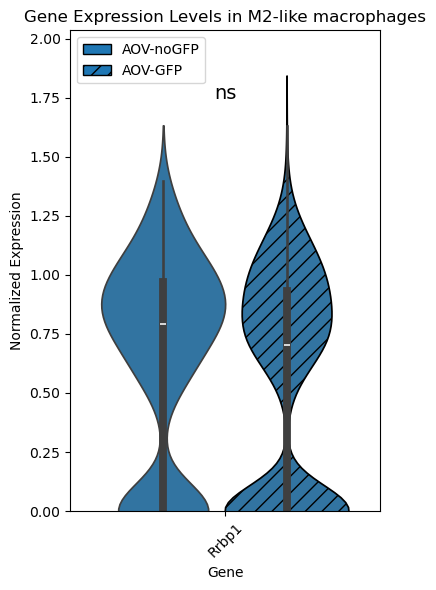

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse
import numpy as np
from matplotlib.patches import Patch

sc.settings.figdir = "FIGURE_3"
# List of genes of interest
genes_of_interest = ['Rrbp1']

# Filter to include only genes present in the dataset
available_genes = [gene for gene in genes_of_interest if gene in cell_subset.raw.var_names]
print(f"Available genes in the dataset: {available_genes}")

# Raise error if none are found
if not available_genes:
    raise ValueError("None of the genes of interest are present in the dataset.")

# Extract expression matrix from .raw
expr_matrix = cell_subset.raw.X.toarray() if scipy.sparse.issparse(cell_subset.raw.X) else cell_subset.raw.X

# Perform log-normalization (log1p) on the expression matrix
normalized_expr_matrix = np.log1p(expr_matrix)

# Create a DataFrame for plotting
data = []
for gene in available_genes:
    gene_index = cell_subset.raw.var_names.get_loc(gene)
    gene_expr = normalized_expr_matrix[:, gene_index]  # Use the normalized expression
    data.append(pd.DataFrame({
        'Condition': cell_subset.obs['condition'].values,
        'Gene': gene,
        'Expression': gene_expr
    }))

plot_data = pd.concat(data, ignore_index=True)

# Debugging
print(plot_data.head())
print(f"Number of rows in plot_data: {len(plot_data)}")

# Raise error if DataFrame is empty
if plot_data.empty:
    raise ValueError("The plot_data DataFrame is empty. Check the gene extraction and subsetting steps.")

# Sort results from stat_res by the 'stat' column in descending order
de = stat_res.results_df
de = de.sort_values('stat', ascending=False)

# Set color palette for the conditions
palette = {'AOV-noGFP': '#1f77b4', 'AOV-GFP': '#1f77b4'}

# Plot violin plot
plt.figure(figsize=(4, 6))
ax = sns.violinplot(
    x='Gene',
    y='Expression',
    hue='Condition',
    data=plot_data,
    palette=palette,
    inner='box',
    hue_order=['AOV-noGFP', 'AOV-GFP']
)

# Apply hatch pattern only to ASham-GFP violins
for i, artist in enumerate(ax.collections):
    if i % 2 == 1:  # ASham-GFP (2nd hue in each gene group)
        artist.set_hatch('//')
        artist.set_edgecolor('black')  # optional: make hatch clearer

# Annotate statistical significance
max_expr = plot_data['Expression'].max()
line_spacing = max_expr * 0.15
text_offset = max_expr * 0.025

for i, gene in enumerate(available_genes):
    gene_data = plot_data[plot_data['Gene'] == gene]
    
    # Padj from your DE results
    padj = de.loc[gene, 'padj'] if gene in de.index else 1.0
    padj = 1.0 if pd.isna(padj) else padj
    
    # Significance symbol
    symbol = '***' if padj < 0.001 else '**' if padj < 0.01 else '*' if padj < 0.05 else 'ns'
    
    # Get maximum box height per gene (from both conditions)
    max_expr_per_gene = gene_data.groupby('Condition')['Expression'].max().max()

    # Small offset above the top box/violin for placing the text
    y = max_expr_per_gene + 0.1  # Adjust as needed
    x = i  # center of the gene group

    ax.text(x, y, symbol, ha='center', va='bottom', fontsize=14)


# Axis settings
plt.ylim(0, plot_data['Expression'].max() * 1.25)
plt.title('Gene Expression Levels in M2-like macrophages')
plt.ylabel('Normalized Expression')
plt.xticks(rotation=45)

# Custom legend with hatch pattern
legend_elements = [
    Patch(facecolor='#1f77b4', edgecolor='black', label='AOV-noGFP'),
    Patch(facecolor='#1f77b4', edgecolor='black', hatch='//', label='AOV-GFP')
]
plt.legend(handles=legend_elements)

# Save and show plot
plt.tight_layout()
plt.savefig('Violin_AOV_GFP vs AOV_noGFP_M2-like macrophages_3.png')
plt.show()


Available genes in the dataset: ['Ucp2']
   Condition  Gene  Expression
0  YSham-GFP  Ucp2    0.000000
1  YSham-GFP  Ucp2    0.760804
2  YSham-GFP  Ucp2    0.000000
3  YSham-GFP  Ucp2    0.790611
4  YSham-GFP  Ucp2    0.848802
Number of rows in plot_data: 3804


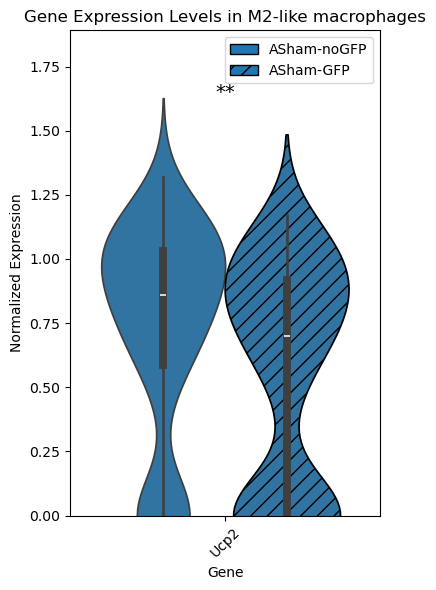

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse
import numpy as np
from matplotlib.patches import Patch

sc.settings.figdir = "FIGURE_3"
# List of genes of interest
genes_of_interest = ['Ucp2']

# Filter to include only genes present in the dataset
available_genes = [gene for gene in genes_of_interest if gene in cell_subset.raw.var_names]
print(f"Available genes in the dataset: {available_genes}")

# Raise error if none are found
if not available_genes:
    raise ValueError("None of the genes of interest are present in the dataset.")

# Extract expression matrix from .raw
expr_matrix = cell_subset.raw.X.toarray() if scipy.sparse.issparse(cell_subset.raw.X) else cell_subset.raw.X

# Perform log-normalization (log1p) on the expression matrix
normalized_expr_matrix = np.log1p(expr_matrix)

# Create a DataFrame for plotting
data = []
for gene in available_genes:
    gene_index = cell_subset.raw.var_names.get_loc(gene)
    gene_expr = normalized_expr_matrix[:, gene_index]  # Use the normalized expression
    data.append(pd.DataFrame({
        'Condition': cell_subset.obs['condition'].values,
        'Gene': gene,
        'Expression': gene_expr
    }))

plot_data = pd.concat(data, ignore_index=True)

# Debugging
print(plot_data.head())
print(f"Number of rows in plot_data: {len(plot_data)}")

# Raise error if DataFrame is empty
if plot_data.empty:
    raise ValueError("The plot_data DataFrame is empty. Check the gene extraction and subsetting steps.")

# Sort results from stat_res by the 'stat' column in descending order
de = stat_res.results_df
de = de.sort_values('stat', ascending=False)

# Set color palette for the conditions
palette = {'ASham-noGFP': '#1f77b4', 'ASham-GFP': '#1f77b4'}

# Plot violin plot
plt.figure(figsize=(4, 6))
ax = sns.violinplot(
    x='Gene',
    y='Expression',
    hue='Condition',
    data=plot_data,
    palette=palette,
    inner='box',
    hue_order=['ASham-noGFP', 'ASham-GFP']
)

# Apply hatch pattern only to ASham-GFP violins
for i, artist in enumerate(ax.collections):
    if i % 2 == 1:  # ASham-GFP (2nd hue in each gene group)
        artist.set_hatch('//')
        artist.set_edgecolor('black')  # optional: make hatch clearer

# Annotate statistical significance
max_expr = plot_data['Expression'].max()
line_spacing = max_expr * 0.15
text_offset = max_expr * 0.025

for i, gene in enumerate(available_genes):
    gene_data = plot_data[plot_data['Gene'] == gene]
    
    # Padj from your DE results
    padj = de.loc[gene, 'padj'] if gene in de.index else 1.0
    padj = 1.0 if pd.isna(padj) else padj
    
    # Significance symbol
    symbol = '***' if padj < 0.001 else '**' if padj < 0.01 else '*' if padj < 0.05 else 'ns'
    
    # Get maximum box height per gene (from both conditions)
    max_expr_per_gene = gene_data.groupby('Condition')['Expression'].max().max()

    # Small offset above the top box/violin for placing the text
    y = max_expr_per_gene + 0.1  # Adjust as needed
    x = i  # center of the gene group

    ax.text(x, y, symbol, ha='center', va='bottom', fontsize=14)


# Axis settings
plt.ylim(0, plot_data['Expression'].max() * 1.25)
plt.title('Gene Expression Levels in M2-like macrophages')
plt.ylabel('Normalized Expression')
plt.xticks(rotation=45)

# Custom legend with hatch pattern
legend_elements = [
    Patch(facecolor='#1f77b4', edgecolor='black', label='ASham-noGFP'),
    Patch(facecolor='#1f77b4', edgecolor='black', hatch='//', label='ASham-GFP')
]
plt.legend(handles=legend_elements)

# Save and show plot
plt.tight_layout()
plt.savefig('Violin_ASham_GFP vs ASham_noGFP_M2-like macrophages_Down.png')
plt.show()


C:\Users\tpsa222\AppData\Local\Temp\ipykernel_3052\637666354.py:81: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(available_genes, rotation=45)


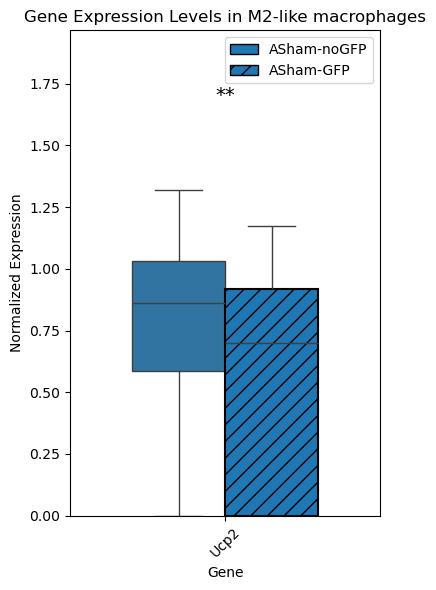

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse
import numpy as np
from matplotlib.patches import Patch

sc.settings.figdir = "FIGURE_3"

# List of genes of interest
genes_of_interest = ['Ucp2']
available_genes = [gene for gene in genes_of_interest if gene in cell_subset.raw.var_names]
if not available_genes:
    raise ValueError("None of the genes of interest are present in the dataset.")

# Expression extraction and normalization
expr_matrix = cell_subset.raw.X.toarray() if scipy.sparse.issparse(cell_subset.raw.X) else cell_subset.raw.X
normalized_expr_matrix = np.log1p(expr_matrix)

data = []
for gene in available_genes:
    gene_index = cell_subset.raw.var_names.get_loc(gene)
    gene_expr = normalized_expr_matrix[:, gene_index]
    data.append(pd.DataFrame({
        'Condition': cell_subset.obs['condition'].values,
        'Gene': gene,
        'Expression': gene_expr
    }))
plot_data = pd.concat(data, ignore_index=True)
if plot_data.empty:
    raise ValueError("Empty plot data.")

de = stat_res.results_df.sort_values('stat', ascending=False)

# Plotting
fig, ax = plt.subplots(figsize=(4, 6))

# Draw boxplot without hatching first
sns.boxplot(
    x='Gene',
    y='Expression',
    hue='Condition',
    data=plot_data,
    palette={'ASham-noGFP': '#1f77b4', 'ASham-GFP': '#1f77b4'},
    hue_order=['ASham-noGFP', 'ASham-GFP'],
    width=0.6,
    fliersize=0,
    ax=ax
)

# Manually apply hatch to the ASham-GFP boxes
# Seaborn arranges artists in order: for each gene, first noGFP then GFP
num_genes = len(available_genes)
for i, box in enumerate(ax.patches):
    if i % 2 == 1:  # Every second box = ASham-GFP
        box.set_hatch('//')
        box.set_edgecolor('black')
        box.set_linewidth(1.5)
        box.set_facecolor('#1f77b4')

# Annotate significance
for i, gene in enumerate(available_genes):
    gene_data = plot_data[plot_data['Gene'] == gene]
    padj = de.loc[gene, 'padj'] if gene in de.index else 1.0
    padj = 1.0 if pd.isna(padj) else padj
    symbol = '***' if padj < 0.001 else '**' if padj < 0.01 else '*' if padj < 0.05 else 'ns'
    max_y = gene_data['Expression'].max() + 0.15
    ax.text(i, max_y, symbol, ha='center', va='bottom', fontsize=14)

# Legend with hatch pattern
legend_elements = [
    Patch(facecolor='#1f77b4', edgecolor='black', label='ASham-noGFP'),
    Patch(facecolor='#1f77b4', edgecolor='black', hatch='//', label='ASham-GFP')
]
ax.legend(handles=legend_elements)

# Final adjustments
ax.set_ylim(0, plot_data['Expression'].max() * 1.3)
ax.set_title('Gene Expression Levels in M2-like macrophages')
ax.set_ylabel('Normalized Expression')
ax.set_xticklabels(available_genes, rotation=45)
plt.tight_layout()
plt.savefig('Boxplot_ASham_GFP_vs_ASham_noGFP_M2-like_macrophages.png')
plt.show()


ValueError: 'AOV-GFP' is not in list

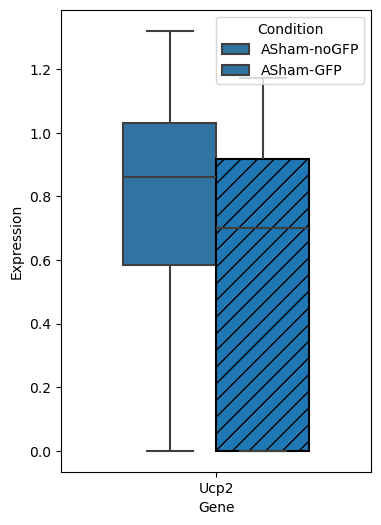

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse
import numpy as np
from matplotlib.patches import Patch

sc.settings.figdir = "FIGURE_3"
genes_of_interest = ['Ucp2']
available_genes = [gene for gene in genes_of_interest if gene in cell_subset.raw.var_names]
if not available_genes:
    raise ValueError("None of the genes of interest are present in the dataset.")

expr_matrix = cell_subset.raw.X.toarray() if scipy.sparse.issparse(cell_subset.raw.X) else cell_subset.raw.X
normalized_expr_matrix = np.log1p(expr_matrix)

data = []
for gene in available_genes:
    gene_index = cell_subset.raw.var_names.get_loc(gene)
    gene_expr = normalized_expr_matrix[:, gene_index]
    data.append(pd.DataFrame({
        'Condition': cell_subset.obs['condition'].values,
        'Gene': gene,
        'Expression': gene_expr
    }))
plot_data = pd.concat(data, ignore_index=True)
if plot_data.empty:
    raise ValueError("Empty plot data.")

de = stat_res.results_df.sort_values('stat', ascending=False)

# Plot setup
fig, ax = plt.subplots(figsize=(4, 6))
sns.boxplot(
    x='Gene', y='Expression', hue='Condition', data=plot_data,
    palette={'ASham-noGFP': '#1f77b4', 'ASham-GFP': '#1f77b4'},
    hue_order=['ASham-noGFP', 'ASham-GFP'],
    width=0.6, fliersize=0, linewidth=1.5, ax=ax
)

# Hatching for ASham-GFP boxes
num_genes = len(available_genes)
for i, box in enumerate(ax.patches):
    if i % 2 == 1:  # ASham-GFP
        box.set_hatch('//')
        box.set_edgecolor('black')
        box.set_linewidth(1.5)
        box.set_facecolor('#1f77b4')

# Overlay individual data points
sns.stripplot(
    x='Gene', y='Expression', hue='Condition', data=plot_data,
    dodge=True, palette={'ASham-noGFP': 'black', 'ASham-GFP': 'black'},
    alpha=0.4, size=4, jitter=True, hue_order=['ASham-noGFP', 'ASham-GFP'], ax=ax
)

# Remove duplicate legend
handles, labels = ax.get_legend_handles_labels()
ax.legend_.remove()

# Custom legend
legend_elements = [
    Patch(facecolor='#1f77b4', edgecolor='black', label='ASham-noGFP'),
    Patch(facecolor='#1f77b4', edgecolor='black', hatch='//', label='ASham-GFP')
]
ax.legend(handles=legend_elements, loc='upper right', frameon=False)

# Significance annotations above box tops (Q3)
for i, gene in enumerate(available_genes):
    sub = plot_data[plot_data['Gene'] == gene]
    groups = sub.groupby('Condition')
    tops = [group['Expression'].quantile(0.75) for name, group in groups]
    max_top = max(tops)
    padj = de.loc[gene, 'padj'] if gene in de.index else 1.0
    padj = 1.0 if pd.isna(padj) else padj
    symbol = '***' if padj < 0.001 else '**' if padj < 0.01 else '*' if padj < 0.05 else 'ns'
    ax.text(i, max_top + 0.15, symbol, ha='center', va='bottom', fontsize=14)

# Axis settings
ax.set_ylim(0, plot_data['Expression'].max() * 1.3)
ax.set_title('Gene Expression in M2-like Macrophages', fontsize=14)
ax.set_ylabel('Log-normalized Expression', fontsize=12)
ax.set_xlabel('')
ax.set_xticklabels(available_genes, rotation=45, ha='right')
sns.despine(trim=True)
ax.tick_params(width=1.5)

# Save
plt.tight_layout()
plt.savefig('Boxplot_ASham_GFP_vs_noGFP_M2_like_pubquality.pdf', dpi=300)
plt.show()


In [23]:
# Redefine the categories in 'Condition' column to include only the desired conditions
plot_data['Condition'] = pd.Categorical(plot_data['Condition'], categories=['ASham-noGFP', 'ASham-GFP'])

# Check the filtered data
print(plot_data['Condition'].unique())


['ASham-GFP', 'ASham-noGFP']
Categories (2, object): ['ASham-noGFP', 'ASham-GFP']


C:\Users\tpsa222\AppData\Local\Temp\ipykernel_3052\2483680376.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(available_genes, rotation=45, ha='right')


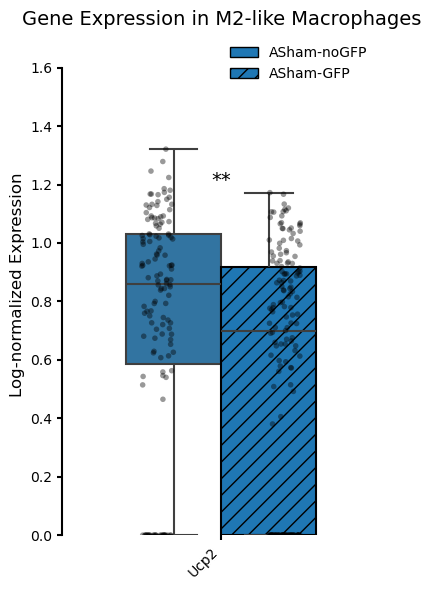

In [27]:
# Plot setup
fig, ax = plt.subplots(figsize=(4, 6))
sns.boxplot(
    x='Gene', y='Expression', hue='Condition', data=plot_data,
    palette={'ASham-noGFP': '#1f77b4', 'ASham-GFP': '#1f77b4'},
    hue_order=['ASham-noGFP', 'ASham-GFP'],
    width=0.6, fliersize=0, linewidth=1.5, ax=ax
)

# Hatching for ASham-GFP boxes
for i, box in enumerate(ax.patches):
    if i % 2 == 1:  # ASham-GFP
        box.set_hatch('//')
        box.set_edgecolor('black')
        box.set_linewidth(1.5)
        box.set_facecolor('#1f77b4')

# Overlay individual data points
sns.stripplot(
    x='Gene', y='Expression', hue='Condition', data=plot_data,
    dodge=True, palette={'ASham-noGFP': 'black', 'ASham-GFP': 'black'},
    alpha=0.4, size=4, jitter=True, hue_order=['ASham-noGFP', 'ASham-GFP'], ax=ax
)

# Remove duplicate legend
handles, labels = ax.get_legend_handles_labels()
ax.legend_.remove()

# Custom legend
legend_elements = [
    Patch(facecolor='#1f77b4', edgecolor='black', label='ASham-noGFP'),
    Patch(facecolor='#1f77b4', edgecolor='black', hatch='//', label='ASham-GFP')
]
ax.legend(handles=legend_elements, loc='upper right', frameon=False)

# Significance annotations above box tops (Q3)
for i, gene in enumerate(available_genes):
    sub = plot_data[plot_data['Gene'] == gene]
    groups = sub.groupby('Condition')
    tops = [group['Expression'].quantile(0.75) for name, group in groups]
    max_top = max(tops)
    padj = de.loc[gene, 'padj'] if gene in de.index else 1.0
    padj = 1.0 if pd.isna(padj) else padj
    symbol = '***' if padj < 0.001 else '**' if padj < 0.01 else '*' if padj < 0.05 else 'ns'
    ax.text(i, max_top + 0.15, symbol, ha='center', va='bottom', fontsize=14)

# Axis settings
ax.set_ylim(0, plot_data['Expression'].max() * 1.3)
ax.set_title('Gene Expression in M2-like Macrophages', fontsize=14)
ax.set_ylabel('Log-normalized Expression', fontsize=12)
ax.set_xlabel('')
ax.set_xticklabels(available_genes, rotation=45, ha='right')

# Ensure the x-axis line is visible
ax.spines['bottom'].set_visible(True)  # Ensure the bottom x-axis line is visible
ax.spines['bottom'].set_linewidth(1.5)  # Set linewidth for the x-axis line
ax.spines['bottom'].set_color('black')  # Set color for the x-axis line
ax.spines['left'].set_visible(True)    # Ensure the y-axis line is visible
ax.spines['left'].set_linewidth(1.5)   # Set linewidth for the y-axis line
ax.spines['left'].set_color('black')   # Set color for the y-axis line
ax.tick_params(width=1.5)

# Remove top and right spines if you prefer
sns.despine(trim=True)

# Save as PNG
plt.tight_layout()
plt.savefig('Boxplot_ASham_GFP_vs_noGFP_M2_like_pubquality.png', dpi=300)

# Show plot
plt.show()


Available genes in the dataset: ['Col1a1', 'Col3a1', 'Col1a2']
   Condition    Gene  Expression
0  YSham-GFP  Col1a1    0.000000
1  YSham-GFP  Col1a1    0.000000
2  YSham-GFP  Col1a1    0.000000
3  YSham-GFP  Col1a1    0.454792
4  YSham-GFP  Col1a1    0.000000
Number of rows in plot_data: 11412


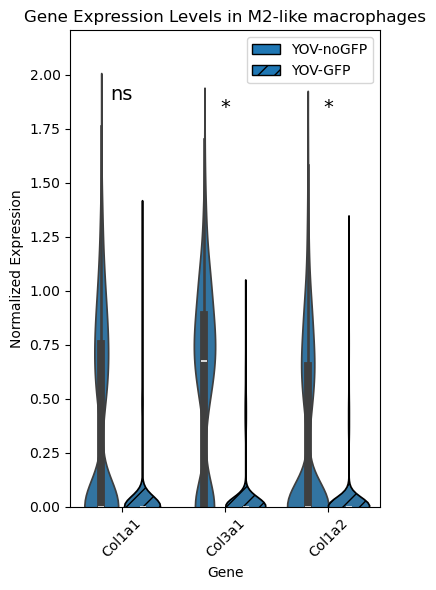

In [88]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse
import numpy as np
from matplotlib.patches import Patch

sc.settings.figdir = "FIGURE_3"
# List of genes of interest
genes_of_interest = ['Col1a1','Col3a1','Col1a2']

# Filter to include only genes present in the dataset
available_genes = [gene for gene in genes_of_interest if gene in cell_subset.raw.var_names]
print(f"Available genes in the dataset: {available_genes}")

# Raise error if none are found
if not available_genes:
    raise ValueError("None of the genes of interest are present in the dataset.")

# Extract expression matrix from .raw
expr_matrix = cell_subset.raw.X.toarray() if scipy.sparse.issparse(cell_subset.raw.X) else cell_subset.raw.X

# Perform log-normalization (log1p) on the expression matrix
normalized_expr_matrix = np.log1p(expr_matrix)

# Create a DataFrame for plotting
data = []
for gene in available_genes:
    gene_index = cell_subset.raw.var_names.get_loc(gene)
    gene_expr = normalized_expr_matrix[:, gene_index]  # Use the normalized expression
    data.append(pd.DataFrame({
        'Condition': cell_subset.obs['condition'].values,
        'Gene': gene,
        'Expression': gene_expr
    }))

plot_data = pd.concat(data, ignore_index=True)

# Debugging
print(plot_data.head())
print(f"Number of rows in plot_data: {len(plot_data)}")

# Raise error if DataFrame is empty
if plot_data.empty:
    raise ValueError("The plot_data DataFrame is empty. Check the gene extraction and subsetting steps.")

# Sort results from stat_res by the 'stat' column in descending order
de = stat_res.results_df
de = de.sort_values('stat', ascending=False)

# Set color palette for the conditions
palette = {'YOV-noGFP': '#1f77b4', 'YOV-GFP': '#1f77b4'}

# Plot violin plot
plt.figure(figsize=(4, 6))
ax = sns.violinplot(
    x='Gene',
    y='Expression',
    hue='Condition',
    data=plot_data,
    palette=palette,
    inner='box',
    hue_order=['YOV-noGFP', 'YOV-GFP']
)

# Apply hatch pattern only to ASham-GFP violins
for i, artist in enumerate(ax.collections):
    if i % 2 == 1:  # ASham-GFP (2nd hue in each gene group)
        artist.set_hatch('//')
        artist.set_edgecolor('black')  # optional: make hatch clearer

# Annotate statistical significance
max_expr = plot_data['Expression'].max()
line_spacing = max_expr * 0.15
text_offset = max_expr * 0.025

for i, gene in enumerate(available_genes):
    gene_data = plot_data[plot_data['Gene'] == gene]
    
    # Padj from your DE results
    padj = de.loc[gene, 'padj'] if gene in de.index else 1.0
    padj = 1.0 if pd.isna(padj) else padj
    
    # Significance symbol
    symbol = '***' if padj < 0.001 else '**' if padj < 0.01 else '*' if padj < 0.05 else 'ns'
    
    # Get maximum box height per gene (from both conditions)
    max_expr_per_gene = gene_data.groupby('Condition')['Expression'].max().max()

    # Small offset above the top box/violin for placing the text
    y = max_expr_per_gene + 0.1  # Adjust as needed
    x = i  # center of the gene group

    ax.text(x, y, symbol, ha='center', va='bottom', fontsize=14)


# Axis settings
plt.ylim(0, plot_data['Expression'].max() * 1.25)
plt.title('Gene Expression Levels in M2-like macrophages')
plt.ylabel('Normalized Expression')
plt.xticks(rotation=45)

# Custom legend with hatch pattern
legend_elements = [
    Patch(facecolor='#1f77b4', edgecolor='black', label='YOV-noGFP'),
    Patch(facecolor='#1f77b4', edgecolor='black', hatch='//', label='YOV-GFP')
]
plt.legend(handles=legend_elements)

# Save and show plot
plt.tight_layout()
plt.savefig('Violin_YOV_GFP vs YOV_noGFP_M2-like macrophages_Down2.png')
plt.show()


Available genes in the dataset: ['Gas6', 'Notch2', 'Igf1']
   Condition  Gene  Expression
0  YSham-GFP  Gas6    1.246113
1  YSham-GFP  Gas6    0.760804
2  YSham-GFP  Gas6    0.000000
3  YSham-GFP  Gas6    1.310783
4  YSham-GFP  Gas6    0.918698
Number of rows in plot_data: 11412


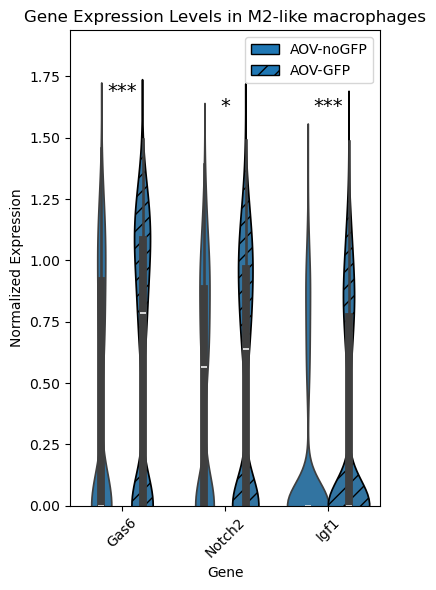

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse
import numpy as np
from matplotlib.patches import Patch

sc.settings.figdir = "FIGURE_3"
# List of genes of interest
genes_of_interest = [ 'Gas6', 'Notch2', 'Igf1' ]

# Filter to include only genes present in the dataset
available_genes = [gene for gene in genes_of_interest if gene in cell_subset.raw.var_names]
print(f"Available genes in the dataset: {available_genes}")

# Raise error if none are found
if not available_genes:
    raise ValueError("None of the genes of interest are present in the dataset.")

# Extract expression matrix from .raw
expr_matrix = cell_subset.raw.X.toarray() if scipy.sparse.issparse(cell_subset.raw.X) else cell_subset.raw.X

# Perform log-normalization (log1p) on the expression matrix
normalized_expr_matrix = np.log1p(expr_matrix)

# Create a DataFrame for plotting
data = []
for gene in available_genes:
    gene_index = cell_subset.raw.var_names.get_loc(gene)
    gene_expr = normalized_expr_matrix[:, gene_index]  # Use the normalized expression
    data.append(pd.DataFrame({
        'Condition': cell_subset.obs['condition'].values,
        'Gene': gene,
        'Expression': gene_expr
    }))

plot_data = pd.concat(data, ignore_index=True)

# Debugging
print(plot_data.head())
print(f"Number of rows in plot_data: {len(plot_data)}")

# Raise error if DataFrame is empty
if plot_data.empty:
    raise ValueError("The plot_data DataFrame is empty. Check the gene extraction and subsetting steps.")

# Sort results from stat_res by the 'stat' column in descending order
de = stat_res.results_df
de = de.sort_values('stat', ascending=False)

# Set color palette for the conditions
palette = {'AOV-noGFP': '#1f77b4', 'AOV-GFP': '#1f77b4'}

# Plot violin plot
plt.figure(figsize=(4, 6))
ax = sns.violinplot(
    x='Gene',
    y='Expression',
    hue='Condition',
    data=plot_data,
    palette=palette,
    inner='box',
    hue_order=['AOV-noGFP', 'AOV-GFP']
)

# Apply hatch pattern only to ASham-GFP violins
for i, artist in enumerate(ax.collections):
    if i % 2 == 1:  # ASham-GFP (2nd hue in each gene group)
        artist.set_hatch('//')
        artist.set_edgecolor('black')  # optional: make hatch clearer

# Annotate statistical significance
max_expr = plot_data['Expression'].max()
line_spacing = max_expr * 0.15
text_offset = max_expr * 0.025

for i, gene in enumerate(available_genes):
    gene_data = plot_data[plot_data['Gene'] == gene]
    
    # Padj from your DE results
    padj = de.loc[gene, 'padj'] if gene in de.index else 1.0
    padj = 1.0 if pd.isna(padj) else padj
    
    # Significance symbol
    symbol = '***' if padj < 0.001 else '**' if padj < 0.01 else '*' if padj < 0.05 else 'ns'
    
    # Get maximum box height per gene (from both conditions)
    max_expr_per_gene = gene_data.groupby('Condition')['Expression'].max().max()

    # Small offset above the top box/violin for placing the text
    y = max_expr_per_gene + 0.1  # Adjust as needed
    x = i  # center of the gene group

    ax.text(x, y, symbol, ha='center', va='bottom', fontsize=14)


# Axis settings
plt.ylim(0, plot_data['Expression'].max() * 1.25)
plt.title('Gene Expression Levels in M2-like macrophages')
plt.ylabel('Normalized Expression')
plt.xticks(rotation=45)

# Custom legend with hatch pattern
legend_elements = [
    Patch(facecolor='#1f77b4', edgecolor='black', label='AOV-noGFP'),
    Patch(facecolor='#1f77b4', edgecolor='black', hatch='//', label='AOV-GFP')
]
plt.legend(handles=legend_elements)

# Save and show plot
plt.tight_layout()
plt.savefig('Violin_AOV_GFP vs AOV_noGFP_M2-like macrophages_Down2.png')
plt.show()


In [ ]:
#monocyte/macrophages

In [ ]:
#8c564b

Available genes in the dataset: ['Gas6', 'Aif1', 'Lgmn']
     Condition  Gene  Expression
0  YSham-noGFP  Gas6    0.705353
1  YSham-noGFP  Gas6    1.258699
2  YSham-noGFP  Gas6    0.986501
3  YSham-noGFP  Gas6    1.460939
4  YSham-noGFP  Gas6    0.618886
Number of rows in plot_data: 13518


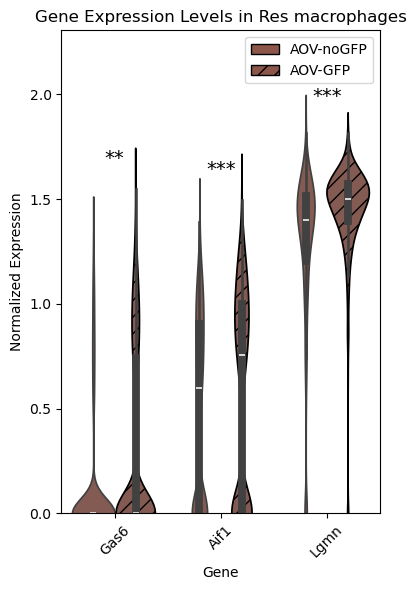

In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse
import numpy as np
from matplotlib.patches import Patch

sc.settings.figdir = "FIGURE_3"
# List of genes of interest
genes_of_interest = ['Gas6', 'Aif1',  'Lgmn']

# Filter to include only genes present in the dataset
available_genes = [gene for gene in genes_of_interest if gene in cell_subset.raw.var_names]
print(f"Available genes in the dataset: {available_genes}")

# Raise error if none are found
if not available_genes:
    raise ValueError("None of the genes of interest are present in the dataset.")

# Extract expression matrix from .raw
expr_matrix = cell_subset.raw.X.toarray() if scipy.sparse.issparse(cell_subset.raw.X) else cell_subset.raw.X

# Perform log-normalization (log1p) on the expression matrix
normalized_expr_matrix = np.log1p(expr_matrix)

# Create a DataFrame for plotting
data = []
for gene in available_genes:
    gene_index = cell_subset.raw.var_names.get_loc(gene)
    gene_expr = normalized_expr_matrix[:, gene_index]  # Use the normalized expression
    data.append(pd.DataFrame({
        'Condition': cell_subset.obs['condition'].values,
        'Gene': gene,
        'Expression': gene_expr
    }))

plot_data = pd.concat(data, ignore_index=True)

# Debugging
print(plot_data.head())
print(f"Number of rows in plot_data: {len(plot_data)}")

# Raise error if DataFrame is empty
if plot_data.empty:
    raise ValueError("The plot_data DataFrame is empty. Check the gene extraction and subsetting steps.")

# Sort results from stat_res by the 'stat' column in descending order
de = stat_res.results_df
de = de.sort_values('stat', ascending=False)

# Set color palette for the conditions
palette = {'AOV-noGFP': '#8c564b', 'AOV-GFP': '#8c564b'}

# Plot violin plot
plt.figure(figsize=(4, 6))
ax = sns.violinplot(
    x='Gene',
    y='Expression',
    hue='Condition',
    data=plot_data,
    palette=palette,
    inner='box',
    hue_order=['AOV-noGFP', 'AOV-GFP']
)

# Apply hatch pattern only to ASham-GFP violins
for i, artist in enumerate(ax.collections):
    if i % 2 == 1:  # ASham-GFP (2nd hue in each gene group)
        artist.set_hatch('//')
        artist.set_edgecolor('black')  # optional: make hatch clearer

# Annotate statistical significance
max_expr = plot_data['Expression'].max()
line_spacing = max_expr * 0.15
text_offset = max_expr * 0.025

for i, gene in enumerate(available_genes):
    gene_data = plot_data[plot_data['Gene'] == gene]
    
    # Padj from your DE results
    padj = de.loc[gene, 'padj'] if gene in de.index else 1.0
    padj = 1.0 if pd.isna(padj) else padj
    
    # Significance symbol
    symbol = '***' if padj < 0.001 else '**' if padj < 0.01 else '*' if padj < 0.05 else 'ns'
    
    # Get maximum box height per gene (from both conditions)
    max_expr_per_gene = gene_data.groupby('Condition')['Expression'].max().max()

    # Small offset above the top box/violin for placing the text
    y = max_expr_per_gene + 0.1  # Adjust as needed
    x = i  # center of the gene group

    ax.text(x, y, symbol, ha='center', va='bottom', fontsize=14)


# Axis settings
plt.ylim(0, plot_data['Expression'].max() * 1.25)
plt.title('Gene Expression Levels in Res macrophages')
plt.ylabel('Normalized Expression')
plt.xticks(rotation=45)

# Custom legend with hatch pattern
legend_elements = [
    Patch(facecolor='#8c564b', edgecolor='black', label='AOV-noGFP'),
    Patch(facecolor='#8c564b', edgecolor='black', hatch='//', label='AOV-GFP')
]
plt.legend(handles=legend_elements)

# Save and show plot
plt.tight_layout()
plt.savefig('Violin_AOV_GFP vs AOV_noGFP_MONO_UP1.png')
plt.show()


Available genes in the dataset: ['Col1a1', 'Col3a1', 'Col1a2']
     Condition    Gene  Expression
0  YSham-noGFP  Col1a1         0.0
1  YSham-noGFP  Col1a1         0.0
2  YSham-noGFP  Col1a1         0.0
3  YSham-noGFP  Col1a1         0.0
4  YSham-noGFP  Col1a1         0.0
Number of rows in plot_data: 13518


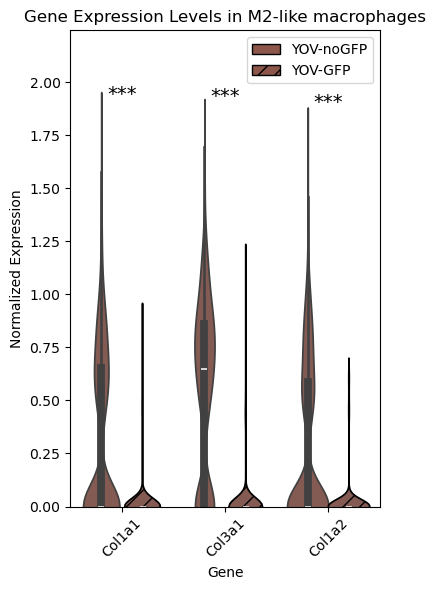

In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse
import numpy as np
from matplotlib.patches import Patch

sc.settings.figdir = "FIGURE_3"
# List of genes of interest
genes_of_interest = ['Col1a1','Col3a1', 'Col1a2']

# Filter to include only genes present in the dataset
available_genes = [gene for gene in genes_of_interest if gene in cell_subset.raw.var_names]
print(f"Available genes in the dataset: {available_genes}")

# Raise error if none are found
if not available_genes:
    raise ValueError("None of the genes of interest are present in the dataset.")

# Extract expression matrix from .raw
expr_matrix = cell_subset.raw.X.toarray() if scipy.sparse.issparse(cell_subset.raw.X) else cell_subset.raw.X

# Perform log-normalization (log1p) on the expression matrix
normalized_expr_matrix = np.log1p(expr_matrix)

# Create a DataFrame for plotting
data = []
for gene in available_genes:
    gene_index = cell_subset.raw.var_names.get_loc(gene)
    gene_expr = normalized_expr_matrix[:, gene_index]  # Use the normalized expression
    data.append(pd.DataFrame({
        'Condition': cell_subset.obs['condition'].values,
        'Gene': gene,
        'Expression': gene_expr
    }))

plot_data = pd.concat(data, ignore_index=True)

# Debugging
print(plot_data.head())
print(f"Number of rows in plot_data: {len(plot_data)}")

# Raise error if DataFrame is empty
if plot_data.empty:
    raise ValueError("The plot_data DataFrame is empty. Check the gene extraction and subsetting steps.")

# Sort results from stat_res by the 'stat' column in descending order
de = stat_res.results_df
de = de.sort_values('stat', ascending=False)

# Set color palette for the conditions
palette = {'YOV-noGFP': '#8c564b', 'YOV-GFP': '#8c564b'}

# Plot violin plot
plt.figure(figsize=(4, 6))
ax = sns.violinplot(
    x='Gene',
    y='Expression',
    hue='Condition',
    data=plot_data,
    palette=palette,
    inner='box',
    hue_order=['YOV-noGFP', 'YOV-GFP']
)

# Apply hatch pattern only to ASham-GFP violins
for i, artist in enumerate(ax.collections):
    if i % 2 == 1:  # ASham-GFP (2nd hue in each gene group)
        artist.set_hatch('//')
        artist.set_edgecolor('black')  # optional: make hatch clearer

# Annotate statistical significance
max_expr = plot_data['Expression'].max()
line_spacing = max_expr * 0.15
text_offset = max_expr * 0.025

for i, gene in enumerate(available_genes):
    gene_data = plot_data[plot_data['Gene'] == gene]
    
    # Padj from your DE results
    padj = de.loc[gene, 'padj'] if gene in de.index else 1.0
    padj = 1.0 if pd.isna(padj) else padj
    
    # Significance symbol
    symbol = '***' if padj < 0.001 else '**' if padj < 0.01 else '*' if padj < 0.05 else 'ns'
    
    # Get maximum box height per gene (from both conditions)
    max_expr_per_gene = gene_data.groupby('Condition')['Expression'].max().max()

    # Small offset above the top box/violin for placing the text
    y = max_expr_per_gene + 0.1  # Adjust as needed
    x = i  # center of the gene group

    ax.text(x, y, symbol, ha='center', va='bottom', fontsize=14)


# Axis settings
plt.ylim(0, plot_data['Expression'].max() * 1.25)
plt.title('Gene Expression Levels in M2-like macrophages')
plt.ylabel('Normalized Expression')
plt.xticks(rotation=45)

# Custom legend with hatch pattern
legend_elements = [
    Patch(facecolor='#8c564b', edgecolor='black', label='YOV-noGFP'),
    Patch(facecolor='#8c564b', edgecolor='black', hatch='//', label='YOV-GFP')
]
plt.legend(handles=legend_elements)

# Save and show plot
plt.tight_layout()
plt.savefig('Violin_YOV_GFP vs YOV_noGFP_MONO_DOWN.png')
plt.show()
